<a href="https://colab.research.google.com/github/biedun/JEPSis/blob/main/pretrained_model/Prediction_Unet_resnet_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model based on Transfer Learning - U-Net with ResNet Encoder

To improve the model's precision in predicting the tumor areas, the encoder part of the U-Net is replaced with the ResNet50 structure. In this way the pretrained weights are kept and can be used for the upsampling in the decoder part in order to improve the dice score.

First part - Set up and training of the U-Net with the ResNet50 from segmentation models library (see Training-Unet-resnet-50.ipynb)

Second part - Prediction with saved model (this notebook)

**2. Predicion with saved model**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import libraries
import tensorflow as tf
import keras
import numpy as np
import nibabel as nib
!pip install nilearn
import nilearn as nl
import nilearn.plotting as nlplt
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Layer
from tensorflow.keras.saving import load_model
from matplotlib.colors import LinearSegmentedColormap
!pip install segmentation-models
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
import pandas as pd
import matplotlib.pyplot as plt
from skimage.transform import rotate
from skimage.util import montage
from io import BytesIO
import random

**Loading the saved pretrained model**

In [ ]:
#Set compile=False as we are not loading it for training, only for prediction.
def load_resnet():
  model1 = load_model('/content/drive/MyDrive/JEPSis/random50/res50_backbone_50epochs_random_50_4.hdf5', compile=False)
  return model1

model1 = load_resnet()

**Loading a random image for prediction**

Necessary to select a data path to a folder which contains NifTi files!

In the function

```
load_image
```

each image of a channel is:
- loaded
- cropped to the size of 224x224 pixels
- converted into an array
- preprocessed regarding the requirements of the pretrained model

**Finally, a prediction for the tumor segmentation is done.**
All slices are scanned and the one with **the maximum tumor area is selected**.

In [ ]:
#Function for loading a random image

def load_images(data_path):
  # take given path to the folder
  samples = os.listdir(data_path) # lists all samples in this folder
  random_image = random.choice(samples) # randomly select a sample
  print('This sample is processed:', random_image)
  # format requirements
  VOLUME_START_AT = 0
  VOLUME_SLICES = 155
  dim = (224, 224)
  n_channels = 3
  # transform nifti file into array and slightly crop the image size to 224x224
  X = np.zeros((VOLUME_SLICES, *dim, n_channels))
  seg = np.zeros((VOLUME_SLICES, *dim))

  for j in range(VOLUME_SLICES):

    temp_image_t2=nib.load(data_path + random_image +'/'+ random_image + '_t2.nii').get_fdata()
    X[j,:,:,0] = temp_image_t2[8:232,8:232,j+VOLUME_START_AT]

    temp_image_t1ce=nib.load(data_path + random_image +'/' + random_image + '_t1ce.nii').get_fdata()
    X[j,:,:,1] = temp_image_t1ce[8:232,8:232,j+VOLUME_START_AT]

    temp_image_flair=nib.load(data_path + random_image  +'/' + random_image + '_flair.nii').get_fdata()
    X[j,:,:,2] = temp_image_flair[8:232,8:232,j+VOLUME_START_AT]

    temp_seg=nib.load(data_path + random_image  +'/' + random_image + '_seg.nii').get_fdata()
    seg[j,:,:] = temp_seg[8:232,8:232,j+VOLUME_START_AT]

  ## Loading preprocessing features
  BACKBONE1 = 'resnet50'
  preprocess_input1 = sm.get_preprocessing(BACKBONE1)

  # preprocess input and make prediction of segmentation
  X_import = preprocess_input1(X)
  y_pred = model1.predict(X_import)
  # choose class of segmentation pixels
  y_pred_argmax=np.argmax(y_pred, axis=3)

  return X_import, y_pred, y_pred_argmax, seg

In [ ]:
data_path = ('/content/drive/MyDrive/JEPSis/Tumor_Data/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/')

In [ ]:
#X_import, y_pred, y_pred_argmax = load_images(data_path)

**Plotting the predicted segmentation**
In the function

```
plot_prediction
```
- the previous function load_images() is called to load the images and execute the prediction of the segmentated tumor
- the slice with the largest tumor area is plotted and previously selected by counting nonzero values of the segmentation classes
- the array of each MRI modality (T1CE, T2, Flair) is loaded and plotted together with the true and predicted segmentation
- a montage of all slices of this MRI scan with the highlighted segmented areas is the last plot


In [ ]:
def plot_prediction(data_path):

  # loading a randomly picked image and make prediction
  X_import, y_pred, y_pred_argmax, seg = load_images(data_path)


  # selecting the slice with the largest tumor area by creating a list of all slices
  nonzero_count=[]
  for i in range(len(seg)):
    nonzero_count.append(np.count_nonzero(seg[i,:,:]))

  # select slice with largest tumor area by index
  max_index = np.argmax(nonzero_count)

  # loading array of selected slice
  test_img = X_import[max_index]

  y_pred_view=y_pred_argmax[max_index,:,:]
  test_img_view_t2=test_img[:,:,0]
  test_img_view_t1ce=test_img[:,:,1]
  test_img_view_t2flair=test_img[:,:,2]
  true_seg = seg[max_index]

  ## Create figure of the colored segmentation
  colors = [(0, 0, 0),  # black
            (0, 0, 1),  # blue for necrotic core
            (0, 1, 0),  # green for edema
            (1, 1, 0)]  # yellow for enhancing tumor

  custom_cmap = LinearSegmentedColormap.from_list('custom_colormap', colors, N=10)

  print('This is the result of your uploaded files: predicted segmentation of the tumor')
  print('The image shows the largest tumor area, which is slice number', max_index)
  fig2 = plt.figure(figsize=(6,6))
  plt.imshow(y_pred_view, cmap=custom_cmap)
  plt.title('Custom Colormap Image')
  plt.axis('off')
  fig2.patch.set_facecolor('black')
  plt.show()

  print('necrotic core in blue, enhancing tumor in yellow and the edema in green')

  ## Create a figure for each MRI modality and segmentation
  print('Overview of the predicted segmentation within the brain cross-sections')
  fig1, axs = plt.subplots(1, 5, figsize=(20, 5))
  fig1.patch.set_facecolor('black')
  for ax, data, title in zip(axs, [test_img_view_t2, test_img_view_t1ce, test_img_view_t2flair, true_seg, y_pred_view], ['T2', 'T1CE', 'FLAIR', 'Original segmentation', 'Predicted segmentation']):
      if title == 'Original segmentation':
        ax.imshow(data, cmap=custom_cmap)
      elif title == 'Predicted segmentation':
        ax.imshow(data, cmap=custom_cmap)
      else:
       ax.imshow(data, cmap="bone")
      ax.set_title(title, color='white' , fontsize = 20)
      ax.axis('off')  # Remove the axes
      ax.set_facecolor('black')  # Set subplot background to black
  plt.subplots_adjust(wspace=0, hspace=0)  # Adjust the space between subplots
  plt.show()

  ## Create a figure of all segmentations

  print('Comprehensive overview of the predicted tumor segmentations over all scans')
  fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
  ax1.imshow(rotate(montage(y_pred_argmax[:,:,:]), 90, resize=True), cmap=custom_cmap)#cmap ='bone')
  ax1.axis('off')
  fig.patch.set_facecolor('black')
  plt.show()

  print('All pictures are AI-generated predictions. No liability is assumed for the results. Please contact your specialist for medical clarification.')


This sample is processed: BraTS20_Training_124
5/5 [==============================] - 56s 11s/step
This is the result of your uploaded files: predicted segmentation of the tumor
The image shows the largest tumor area, which is slice number 75


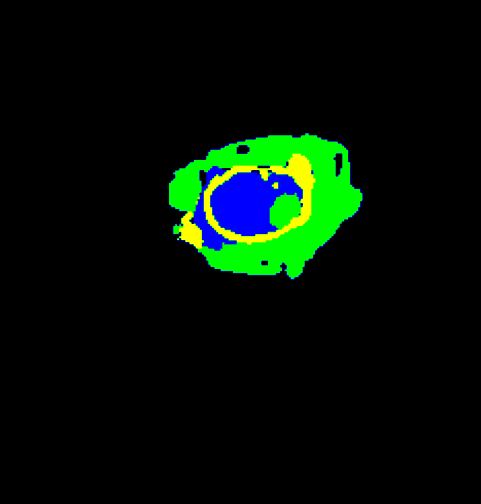

necrotic core in blue, enhancing tumor in yellow and the edema in green
Overview of the predicted segmentation within the brain cross-sections


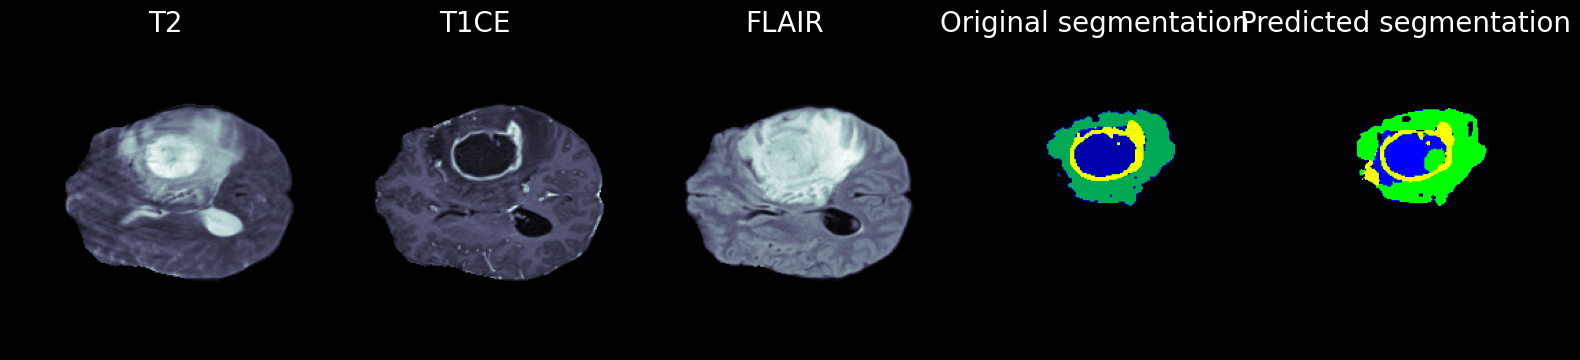

Comprehensive overview of the predicted tumor segmentations over all scans


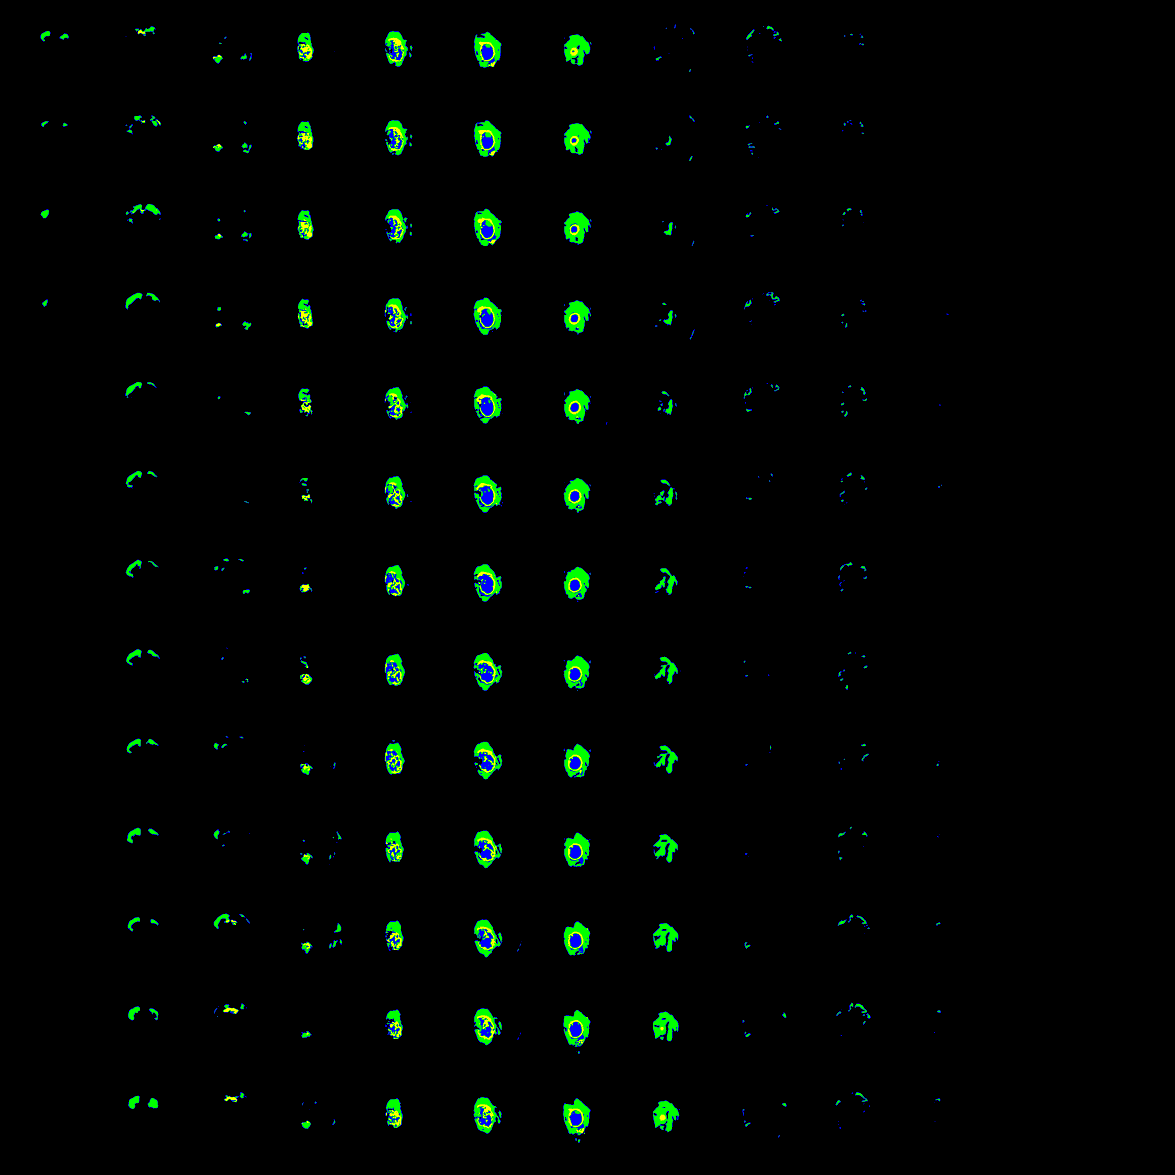

All pictures are AI-generated predictions. No liability is assumed for the results. Please contact your specialist for medical clarification.


In [ ]:
plot_prediction(data_path) # this step takes up to two minutes